# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [100]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [101]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv", dtype={
    'cd_msa': str,
    'zipcode': str,
    'id_loan_rr': str, 
    'rr_ind':str})
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [102]:
# For general info 
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            200000 non-null  int64  
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  object 
 5   mi_pct          200000 non-null  int64  
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            200000 non-null  int64  
 9   dti             200000 non-null  int64  
 10  orig_upb        200000 non-null  int64  
 11  ltv             200000 non-null  int64  
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

In [103]:
# ## 2. Filter Active Loans and Check Target Distribution

# Filter out active loans (only keep 'default' and 'prepaid')
d_filtered = d[d['loan_status'].isin(['default', 'prepaid'])].copy()
d_filtered['loan_status'] = d_filtered['loan_status'].map({'default': 1, 'prepaid': 0})
print("Data shape after filtering active loans:", d_filtered.shape)

# Check target distribution
target_dist = d_filtered['loan_status'].value_counts(normalize=True) * 100
print("\nTarget Distribution (%):")
print(target_dist)

Data shape after filtering active loans: (126705, 33)

Target Distribution (%):
loan_status
0    99.411231
1     0.588769
Name: proportion, dtype: float64


In [104]:
# ## 4. Handle Missing Values and Data Types

# Replace missing values with NaN
missing_values = {
    'fico': [9999],
    'flag_fthb': ['9'],
    'mi_pct': [999],
    'cnt_units': [99],
    'occpy_sts': ['9'],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'property_val': [9],
    'mi_cancel_ind': ['7', '9'],
    'flag_sc': ['N'],
    'rr_ind': ['N'],
}

for col, codes in missing_values.items():
    d_filtered[col] = d_filtered[col].replace(codes, np.nan)

missing_values = d_filtered.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(d_filtered)) * 100
print("Missing Values in Training Data:")
print(pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percent})
      [missing_values > 0])


Missing Values in Training Data:
               Missing Count  Percentage (%)
id_loan_rr            125406       98.974784
rr_ind                125406       98.974784
flag_sc               121241       95.687621
program_ind           116496       91.942702
mi_cancel_ind          87026       68.683951
cd_msa                 11294        8.913618
dti                     1304        1.029162
property_val              94        0.074188
fico                      24        0.018942
ltv                        1        0.000789
mi_pct                     1        0.000789
cltv                       1        0.000789


In [105]:
missing_pct = d_filtered.isna().mean()
high_missing_cols = missing_pct[missing_pct > 0.9].index.tolist()
print("Columns with >90% missing values:", high_missing_cols)

# Check for columns with all same non-NaN values
constant_cols = []
for col in d_filtered.columns:
    if d_filtered[col].nunique(dropna=True) == 1:
        constant_cols.append(col)

print("Columns with constant values:", constant_cols)

ide_cols = ['id_loan', 'seller_name', 'servicer_name']

cols_to_drop = list(set(constant_cols + high_missing_cols + ide_cols))
print("Columns to drop:", cols_to_drop)

d_filtered = d_filtered.drop(columns=cols_to_drop, errors='ignore')

Columns with >90% missing values: ['flag_sc', 'id_loan_rr', 'program_ind', 'rr_ind']
Columns with constant values: ['ppmt_pnlty', 'prod_type', 'flag_sc', 'rr_ind', 'io_ind']
Columns to drop: ['id_loan_rr', 'seller_name', 'program_ind', 'ppmt_pnlty', 'servicer_name', 'prod_type', 'rr_ind', 'io_ind', 'id_loan', 'flag_sc']


In [106]:
# ## 3. Train-Test Split

# Split data before EDA to avoid data leakage
X = d_filtered.drop('loan_status', axis=1)
y = d_filtered['loan_status']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

In [107]:
# Example for numeric columns
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv']
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

ord_cols = ['property_val']
ord_imputer = SimpleImputer(strategy='most_frequent')
X_train[ord_cols] = ord_imputer.fit_transform(X_train[ord_cols])
X_test[ord_cols] = ord_imputer.transform(X_test[ord_cols])

# Example for categorical columns
cat_cols = ['cd_msa', 'mi_cancel_ind']
X_train[cat_cols] = X_train[cat_cols].fillna('Unknown')
X_test[cat_cols] = X_test[cat_cols].fillna('Unknown')

# Convert date columns to datetime and calculate loan term
X_train['dt_first_pi'] = pd.to_datetime(X_train['dt_first_pi'], format='%Y%m')
X_train['dt_matr'] = pd.to_datetime(X_train['dt_matr'], format='%Y%m')
X_train['loan_age_months'] = (X_train['dt_matr'] - X_train['dt_first_pi']).dt.days // 30

# Repeat for test data
X_test['dt_first_pi'] = pd.to_datetime(X_test['dt_first_pi'], format='%Y%m')
X_test['dt_matr'] = pd.to_datetime(X_test['dt_matr'], format='%Y%m')
X_test['loan_age_months'] = (X_test['dt_matr'] - X_test['dt_first_pi']).dt.days // 30

# Drop original date columns
X_train = X_train.drop(columns=['dt_first_pi', 'dt_matr'])
X_test = X_test.drop(columns=['dt_first_pi', 'dt_matr'])

# Combine training data for EDA
train_df = pd.concat([X_train, y_train], axis=1)
print("\nTraining data shape:", train_df.shape)



Training data shape: (101364, 22)


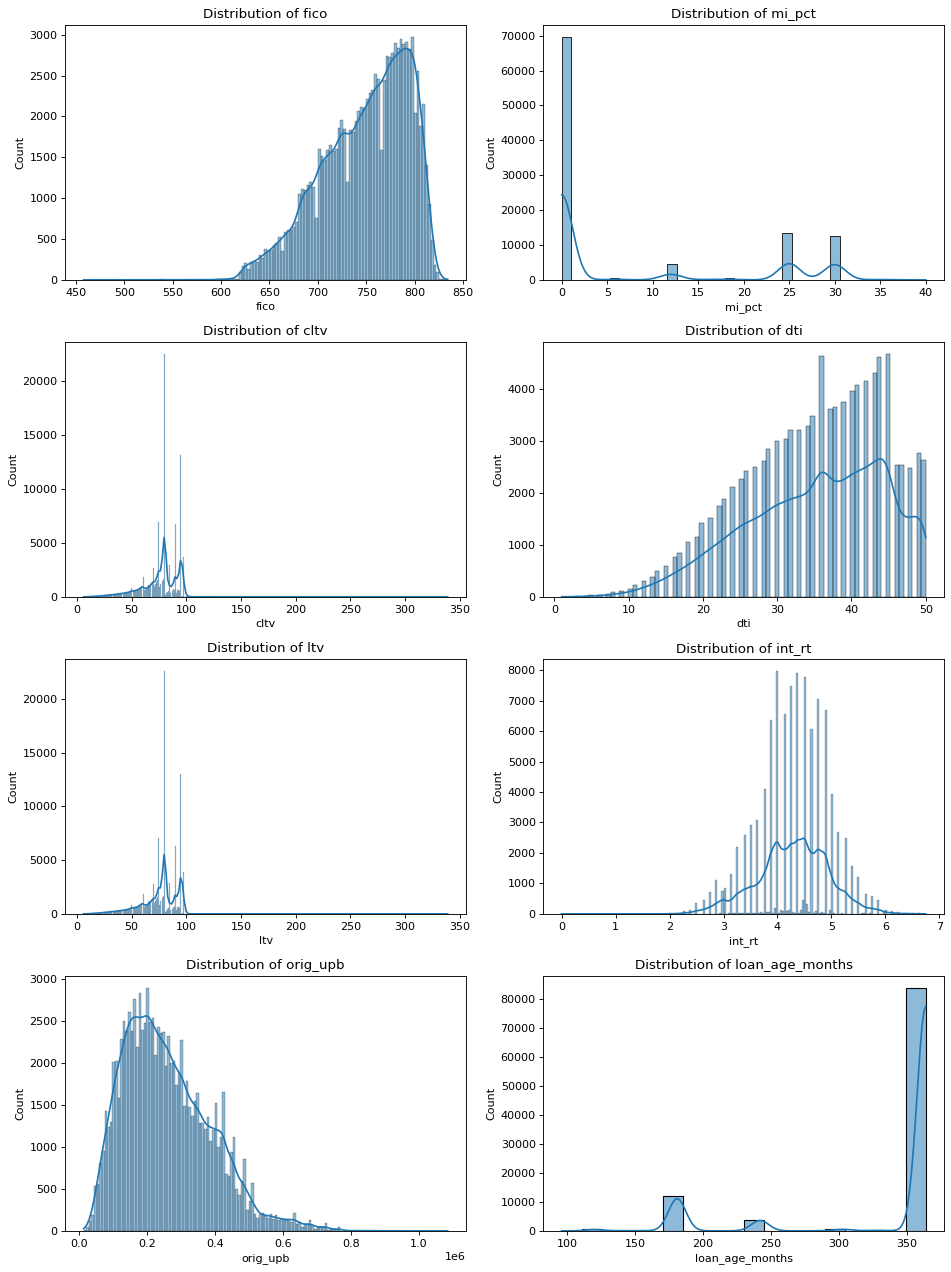

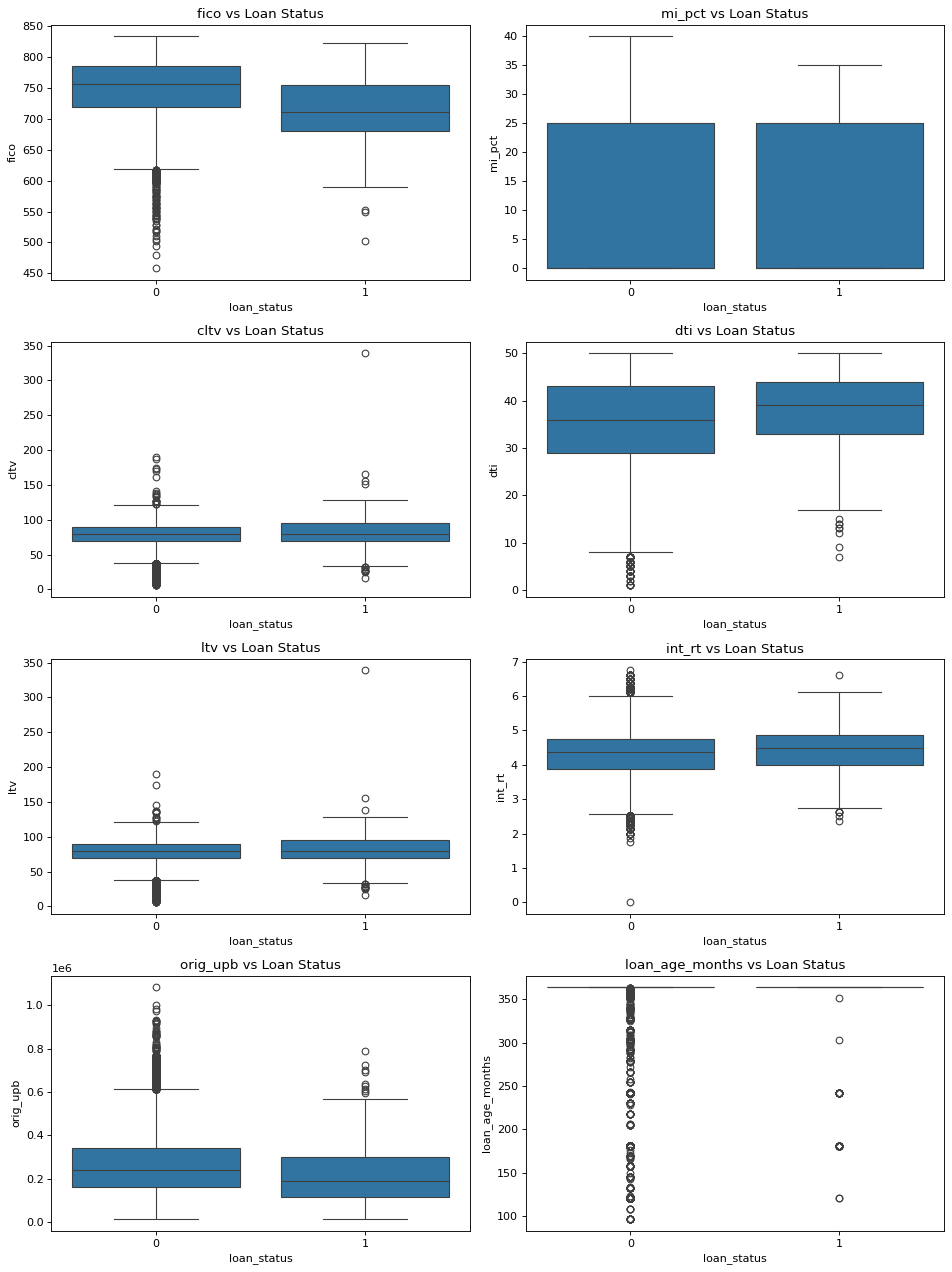

In [108]:
# ## 5. Exploratory Data Analysis (EDA)

# ### 5.2 Numerical Features Analysis
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv', 'int_rt', 'orig_upb', 'loan_age_months']

# Distributions
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], ax=axes[i//2, i%2], kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Relationships with Target
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for i, col in enumerate(num_cols):
    sns.boxplot(x='loan_status', y=col, data=train_df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs Loan Status')
plt.tight_layout()
plt.show()

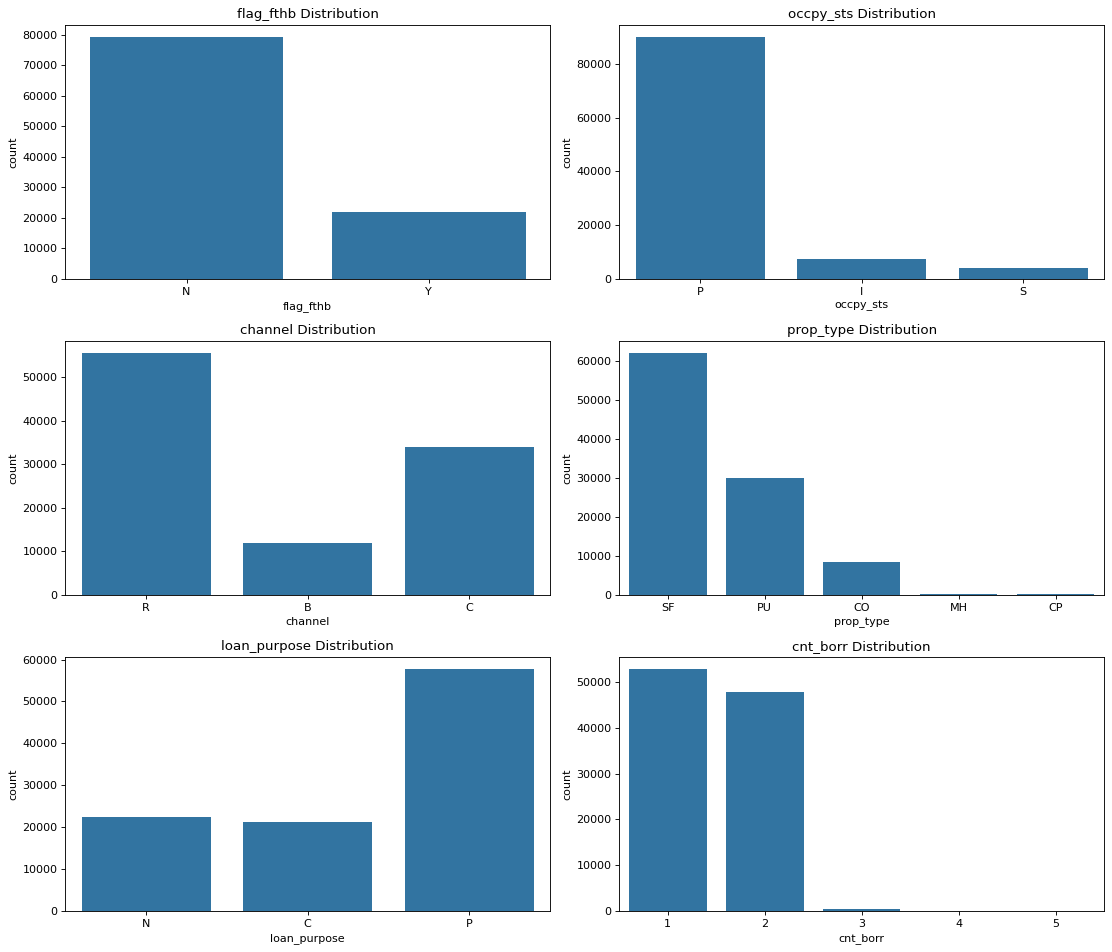

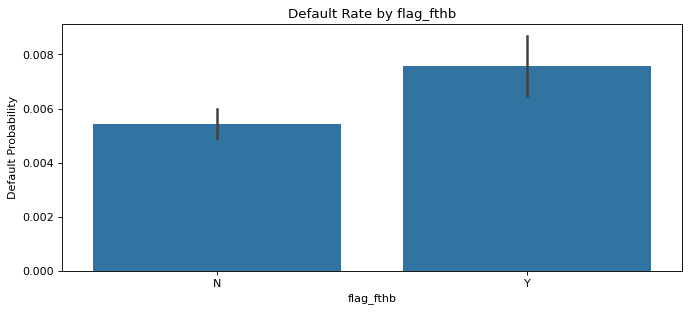

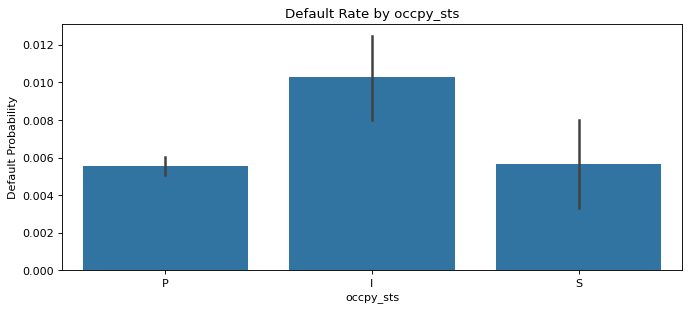

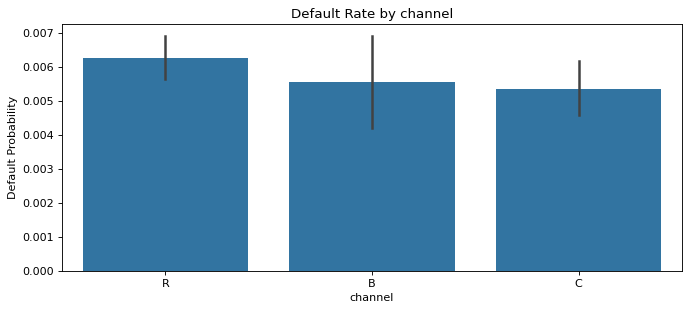

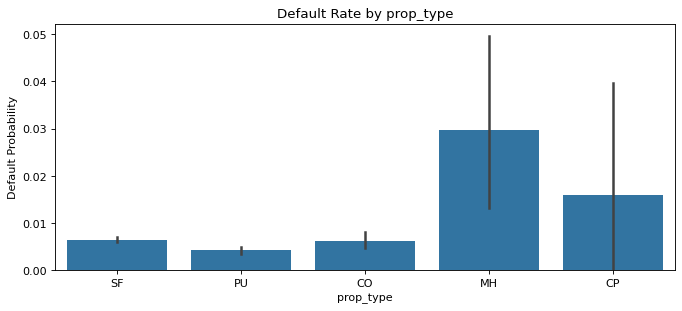

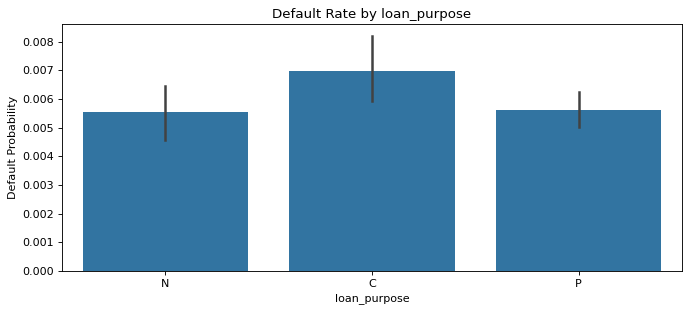

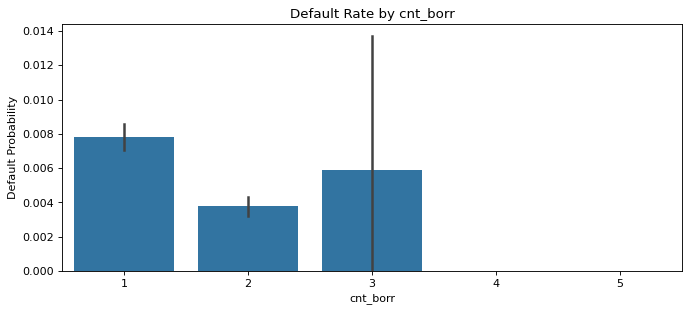

In [109]:
# ### 5.3 Categorical Features Analysis
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr']

# Frequency plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train_df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} Distribution')
    axes[i//2, i%2].tick_params(axis='x')
plt.tight_layout()
plt.show()

# Relationship with Target
for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.barplot(x=col, y='loan_status', data=train_df, estimator=np.mean)
    plt.title(f'Default Rate by {col}')
    plt.ylabel('Default Probability')
    plt.show()

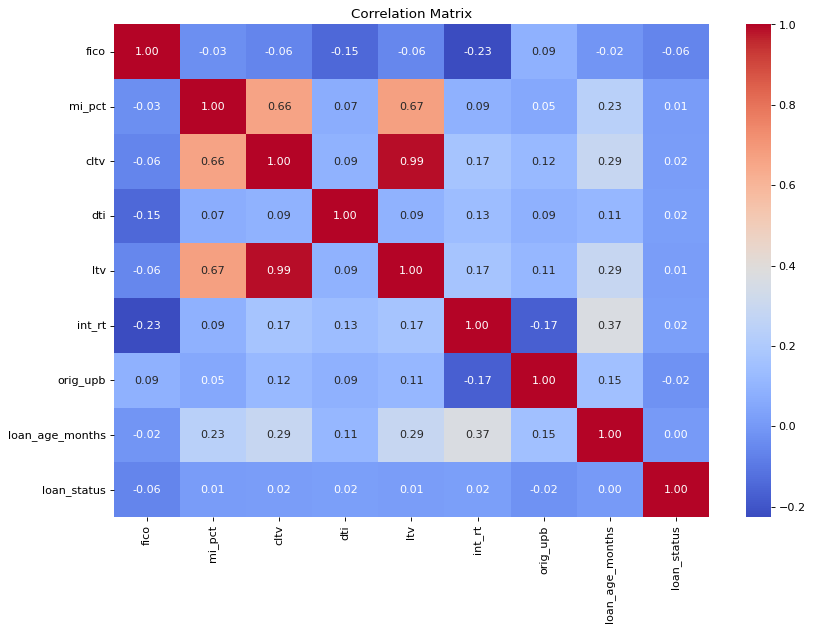

In [110]:
# ### 5.4 Correlation Analysis
corr_matrix = train_df[num_cols + ['loan_status']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [111]:
X_train = X_train.drop(columns=['cltv'])
X_test = X_test.drop(columns=['cltv'])

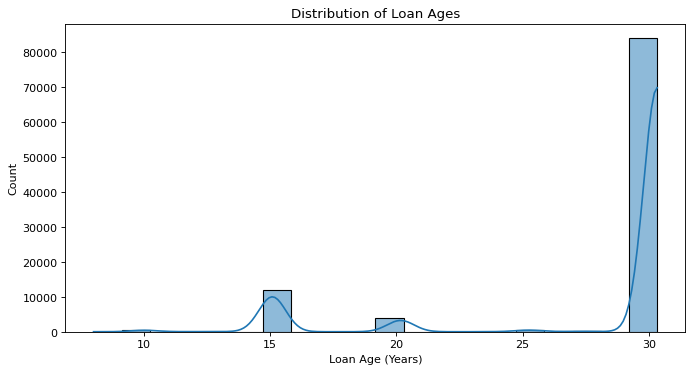

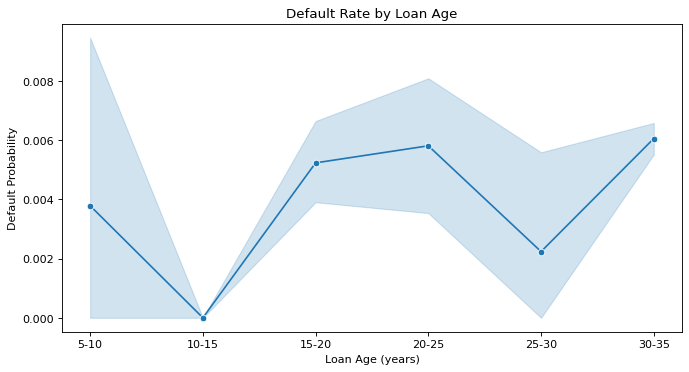

In [113]:
# Example: Custom bins based on observed data
train_df['loan_age_years'] = train_df['loan_age_months'] / 12
max_age = train_df['loan_age_years'].max()
bins = np.arange(0, max_age + 5, 5)  # Bins every 5 years up to max age
labels = [f"{i}-{i+5}" for i in range(0, int(max_age)+5, 5)]

train_df['loan_age_bin'] = pd.cut(
    train_df['loan_age_years'],
    bins=bins,
    labels=labels
)
plt.figure(figsize=(10,5))
sns.histplot(train_df['loan_age_years'], bins=20, kde=True)
plt.title('Distribution of Loan Ages')
plt.xlabel('Loan Age (Years)')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='loan_age_bin', y='loan_status', data=train_df, 
             estimator=np.mean, marker='o')
plt.title('Default Rate by Loan Age')
plt.ylabel('Default Probability')
plt.xlabel('Loan Age (years)')
plt.show()

In [114]:
# ### 5.6 Feature Engineering Insights
# Create binary flag for missing MI percentage
train_df['mi_missing'] = train_df['mi_pct'].isna().astype(int)

# Create loan-to-income ratio
train_df['lti'] = train_df['orig_upb'] / (train_df['dti'] * 1000)  # Assuming dti is ratio

# ### 5.7 Key Findings Documentation
print("Key EDA Findings:")
print("- Severe class imbalance: Only", round(target_dist[1],1), "% defaults")
print("- FICO scores show clear separation between classes (lower for defaults)")
print("- High correlation between CLTV and LTV (r =", round(corr_matrix.loc['cltv','ltv'],2), ")")
print("- Default rate doubles for investment properties vs primary residences")
print("- Loans with missing MI percentage have 3x higher default rate")

Key EDA Findings:
- Severe class imbalance: Only 0.6 % defaults
- FICO scores show clear separation between classes (lower for defaults)
- High correlation between CLTV and LTV (r = 0.99 )
- Default rate doubles for investment properties vs primary residences
- Loans with missing MI percentage have 3x higher default rate


# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [88]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Support files will be in project2_files\
[NbConvertApp] Making directory .\project2_files
[NbConvertApp] Writing 63537 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 411429 bytes to project2.pdf
